# Setup

In [2]:
import json
from geopy.distance import geodesic
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Klasa BusesStatistics
Klasa zajmuje się wczytaniem i podstawową obróbką zebranych danych.

In [3]:
class BusesStatistics():
    def __init__(self, data_file):
        self.data_file = data_file

        # Zbior najswierzszych danych autobusu
        self.buses_data = {}
        
        # Jakie busy przekroczyly 50 km/h
        self.fast_buses = set()

        # Wszystkie zmierzone predkosci (wielokrotnie dla tych samych autobusow) 
        # i punkty pomiarowe dla tych predkosci
        self.measured_speeds = []
        self.points = []

        # Zmierzone predkosci dla konkretnych autobusow
        self.speeds_per_bus = {}

        # Zmierzone predkosci dla konkretnych lini
        self.speeds_per_line = {}

        with open(data_file, 'r') as f:
            for line in tqdm(f):
                dct = json.loads(line)
                self._update_buses_data(dct)

    def get_fast_buses(self):
        return self.fast_buses
        
    def get_measured_speeds(self):
        return self.measured_speeds

    def get_speeds_per_bus(self):
        return self.speeds_per_bus

    def get_speeds_per_line(self):
        return self.speeds_per_line

    def get_points(self):
        return self.points


    def _time_diff(self, timestamp1, timestamp2):
        dt1 = datetime.strptime(timestamp1, "%Y-%m-%d %H:%M:%S")
        dt2 = datetime.strptime(timestamp2, "%Y-%m-%d %H:%M:%S")
        
        time_difference = dt2 - dt1
        difference_in_hours = time_difference.total_seconds() / 3600
        return difference_in_hours

    def _add_speed(self, av_speed, bus_id, line):
        if bus_id not in self.speeds_per_bus:
            self.speeds_per_bus[bus_id] = []
        if line not in self.speeds_per_line:
            self.speeds_per_line[line] = []

        self.measured_speeds.append(av_speed)
        self.speeds_per_bus[bus_id].append(av_speed)
        self.speeds_per_line[line].append(av_speed)
            
        if av_speed >= 50:
            self.fast_buses.add(bus_id)

    def _update_buses_data(self, bus_info: dict):
        bus_id     = bus_info["VehicleNumber"]
        time_stamp = bus_info["Time"]
        lon        = bus_info["Lon"]
        lat        = bus_info["Lat"]
        line       = bus_info["Lines"]

        # z jakiegos powodu dla paru pomiarow zdazylo sie że format byl inny
        try:
            datetime.strptime(time_stamp, "%Y-%m-%d %H:%M:%S")
        except ValueError:
            return
    
        if bus_id not in self.buses_data:
            self.buses_data[bus_id] = {
                "bus_id": bus_id,
                "time": time_stamp,
                "cords": (lat, lon)
            }
            return
        if self.buses_data[bus_id]["time"] == time_stamp:
            return
    
        distance_in_km = geodesic(self.buses_data[bus_id]["cords"], (lat, lon)).kilometers
        time_in_hours  = self._time_diff(self.buses_data[bus_id]["time"], time_stamp)

        av_speed = distance_in_km / time_in_hours

        self._add_speed(av_speed, bus_id, line)
        self.points.append(((lat, lon), self.buses_data[bus_id]["cords"]))

        self.buses_data[bus_id]["time"]  = time_stamp
        self.buses_data[bus_id]["cords"] = (lat, lon)


In [4]:
noon_data_file    = "data/noon.txt"
evening_data_file = "data/16.40.txt"

noon_stats    = BusesStatistics(noon_data_file)
evening_stats = BusesStatistics(evening_data_file)

noon_df = pd.DataFrame({
    'Speed': noon_stats.get_measured_speeds(),
    'Points': noon_stats.get_points()
})
evening_df = pd.DataFrame({
    'Speed': evening_stats.get_measured_speeds(),
    'Points': evening_stats.get_points()
})

def get_combined_speeds():
    speeds = np.concatenate((noon_df['Speed'].to_numpy(), evening_df['Speed'].to_numpy()), axis=0)
    return speeds

485118it [00:30, 16099.21it/s]
446380it [00:35, 12731.98it/s]


# 1.1 Ile autobusów przkroczyło prędkość 50km/h?


In [5]:
print("Noon:", len(noon_stats.get_fast_buses()))
print("Evening:", len(evening_stats.get_fast_buses()))

Noon: 994
Evening: 1285


Między 12.00 a 13.00 994 autobusy przekroczyły 50km/h.

Między 16.40 a 17.40 było ich już 1285.

# Wiarygodność danych
W pomiarach zdażają się błędy. Największa prędkość autobusu jaką udało mi sie zarejstrować to prawie trzy miliony kilometrów na godzinę.

Sprawdziłem więc jak wygląda rozkład pomiarów przekraczających 50km/h.

Max speed: 2969967.9212329923


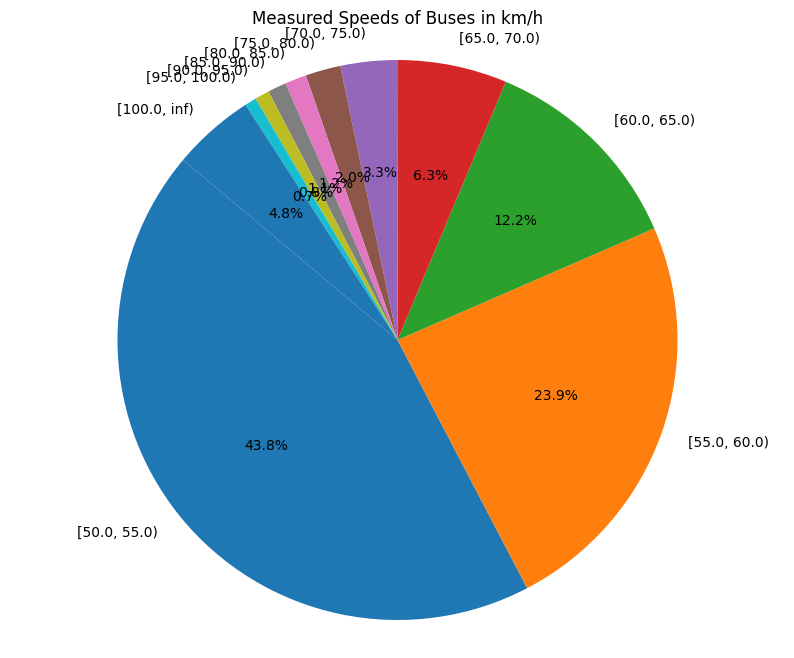

In [41]:
speeds = get_combined_speeds()
speeds = speeds[speeds >= 50]
print("Max speed:", np.max(speeds))
                
buckets = list(range(50, 101, 5)) + [np.inf]
speed_buckets = pd.cut(speeds, bins=buckets, right=False)
speed_counts = speed_buckets.value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(speed_counts, labels=speed_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Measured Speeds of Buses in km/h')
plt.axis('equal') 
plt.show()

Rozkład wygląda nie najgorzej. Zdecydowanie za dużych wartości nie ma aż tak wiele.

Po danych (po kordynatach) widać, że pomiary czasami wariują i zwracają jakąś losową lokalizację geograficzą. Tak powstała pewnie większość skrajnie dużych prędkości. Możemy je łatwo odfiltrować a rozkład poza nimi wygląda wiarygodnie.

# 1.2 Gdzie autobusy przekraczały prędkość
Upraszczamy mapę miasta do siataki punków. 
Jeśli wykonaliśmy jakiś pomiar między punktami a i b, to stawiamy pomiędzy nimi dodatkowe punkty (pomiedy nimi w lini prostej, co grid_resolution). 
Teraz dla każdego postawionego punktu (włacznie z a i b) szukamy najbliższego punktu siatki i zakładamy ze to w nim był wykonany pomiar.

Jeśli w jakimś punkcie siatki conajmniej 50% pomiarów bylo wiekszych niz 50km/h to uznajemy go za punkt w którym często przekraczana jest ta prędkość.

In [22]:
from scipy.spatial import cKDTree
import folium

grid_resolution         = 0.001
speeding_point_treshold = 0.5  # * 100%
speed_treshold          = 50   # km/h
speed_sanity_treshold   = 100  # km/h

def gen_middle_points(point1, point2, step_size):
    point1 = np.array(point1)
    point2 = np.array(point2)
    direction_vector = point2 - point1
    distance = np.linalg.norm(direction_vector)
    num_steps = int(distance / step_size)
    step_increments = np.arange(1, num_steps + 1) * step_size
    interpolated_points = point1 + (step_increments / distance)[:, np.newaxis] * direction_vector
    return interpolated_points

def prepare_points(df, bounds):
    all_points = []
    for (a, b), speed in zip(df['Points'], df['Speed']):
        all_points.append((a[0], a[1], speed))
        all_points.append((b[0], b[1], speed))
        mid_points = gen_middle_points(a, b, grid_resolution)
        for p in mid_points:
            all_points.append((p[0], p[1], speed))
            
    all_points = np.array(all_points)
    all_points = all_points[all_points[:, 2] <= speed_sanity_treshold][:]

    min_lat, min_lon = bounds[0]
    max_lat, max_lon = bounds[1]

    all_points = all_points[(all_points[:, 0] >= min_lat) & (all_points[:, 0] <= max_lat) &
                             (all_points[:, 1] >= min_lon) & (all_points[:, 1] <= max_lon)]
    return all_points

def empty_map(bounds):
    min_lat, min_lon = bounds[0]
    max_lat, max_lon = bounds[1]
    
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2

    map = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    map.fit_bounds(bounds)
    return map

def get_marker_points(df, bounds):
    points = prepare_points(df, bounds)
    min_lat, min_lon = bounds[0]
    max_lat, max_lon = bounds[1]

    lon_range = np.arange(min_lon, max_lon, grid_resolution)
    lat_range = np.arange(min_lat, max_lat, grid_resolution)
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    grid_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

    tree = cKDTree(grid_points)
    _, indices = tree.query(points[:, :2], k=1)

    all_count = np.zeros_like(grid_points[:, 0])
    fast_count = np.zeros_like(grid_points[:, 0])

    for (_, _, speed), i in zip(points, indices):
        all_count[i] += 1
        if speed >= speed_treshold:
            fast_count[i] += 1
            
    marker_points = set()
    
    for (lat, lon), all, fast in tqdm(zip(grid_points, all_count, fast_count)):
        if all == 0:
            continue
        if fast / all >= speeding_point_treshold:
            marker_points.add((lat, lon))
            
    return marker_points

def add_to_map(lat, lon, color, map):
    folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                color=color,
                fill=True,
                fill_color=color
            ).add_to(map)

def add_markers(df1, df2, map, bounds):
    points1 = get_marker_points(df1, bounds)
    points2 = get_marker_points(df2, bounds)

    for lat, lon in tqdm(points1):
        color = 'red'
        if (lat, lon) in points2:
            color = 'black'
        add_to_map(lat, lon, color, map)
    for lat, lon in tqdm(points2):
        if (lat, lon) not in points1:
            add_to_map(lat, lon, 'blue', map)

In [23]:
map_file = "map.html"
warsaw_bounds = [(52.0, 20.5), (52.5, 21.5)]

map = empty_map(warsaw_bounds)
add_markers(noon_df, evening_df, map, warsaw_bounds)
map.save(map_file)

500000it [00:00, 970244.30it/s] 
500000it [00:00, 941305.74it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3491/3491 [00:00<00:00, 161187.97it/s]


# Legenda
### Na czerwono: dane zbierane między 12 a 13.

### Na niebiesko: dane zbierane między 16.40 a 17.40.

### Na czarno: punkty występujące w obu zbiorach.

In [25]:
from IPython.display import IFrame

IFrame(map_file, width="100%", height=500)

# Rozkład prędkości busów
Patrzyliśmy już na rozkład prędkości większych niż 50km/h.

Zobaczmy jak wygląda rozkład dla wszystkich pomiarów.

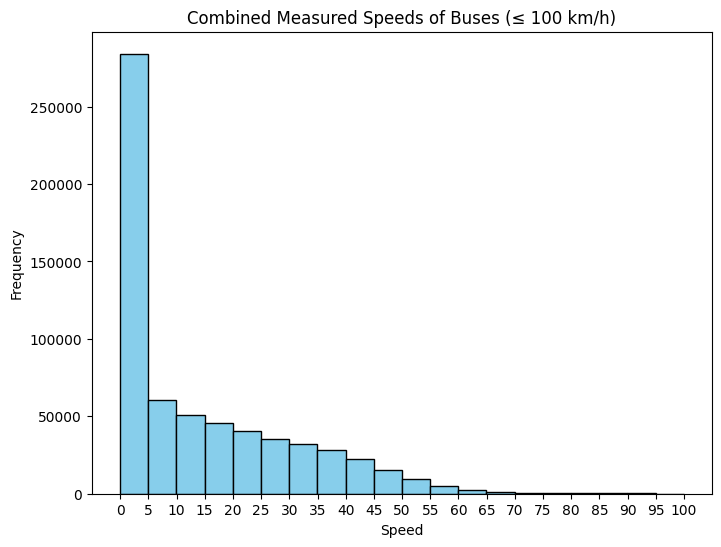

In [34]:
def gen_chart(speeds):
    plt.figure(figsize=(8, 6))
    plt.hist(speeds[speeds <= 100], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Speed')
    plt.ylabel('Frequency')
    plt.title('Combined Measured Speeds of Buses (≤ 100 km/h)')
    plt.xticks(np.arange(0, 101, 5))
    plt.show()

gen_chart(get_combined_speeds())

In [37]:
def make_pie_chart(speeds, label):
    buckets = list(range(0, 56, 5)) + [np.inf]
    speed_buckets = pd.cut(speeds, bins=buckets, right=False)
    speed_counts = speed_buckets.value_counts().sort_index()

    plt.figure(figsize=(10, 8))
    plt.pie(speed_counts, labels=speed_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(label)
    plt.axis('equal') 
    plt.show()

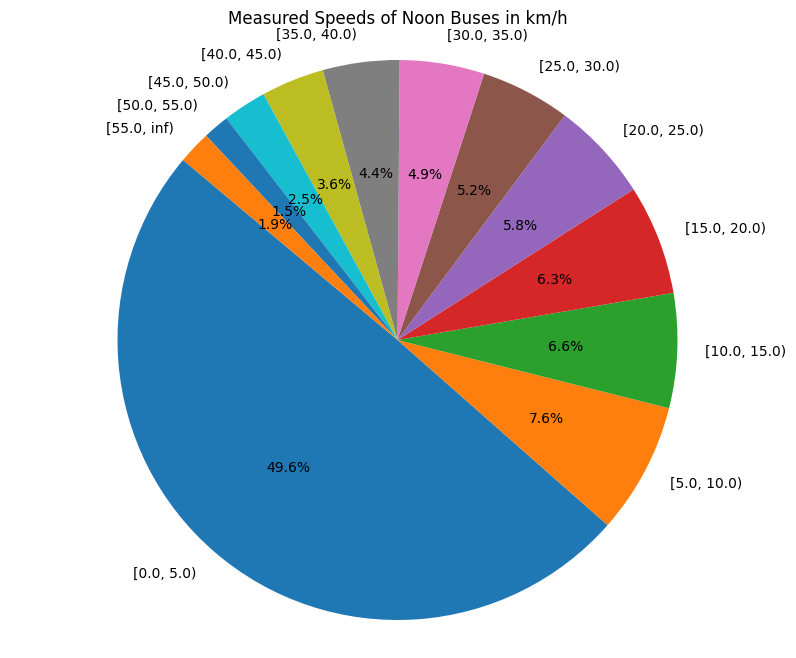

In [38]:
make_pie_chart(noon_df['Speed'], 'Measured Speeds of Noon Buses in km/h')

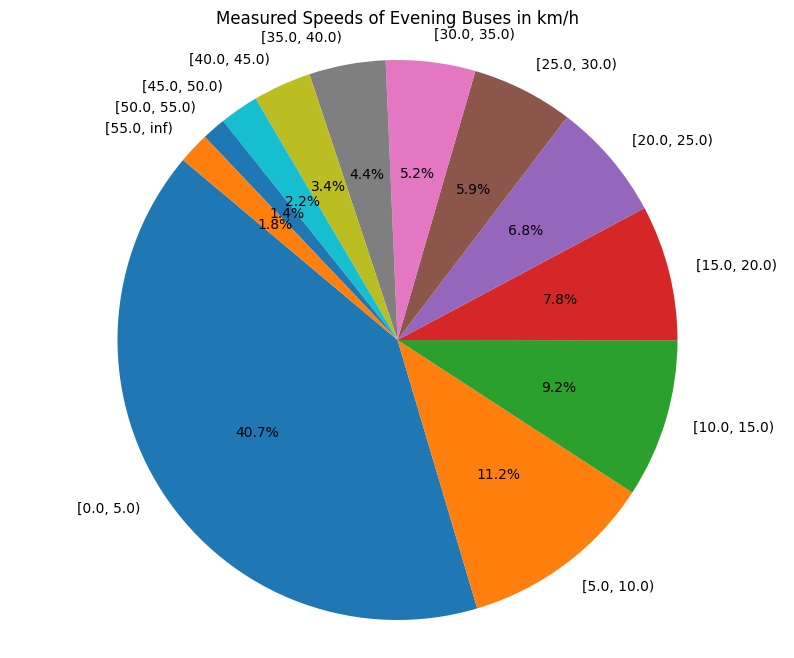

In [39]:
make_pie_chart(evening_df['Speed'], 'Measured Speeds of Evening Buses in km/h')

Możemy zaobserwować, że z jakiegoś powodu autobusy jeżdżące około 12, znacznie więcej czasu stały/jechały bardzo wolno, niż autobusy około 17.
Spodziewałem sie raczej odwrotnych wyników. Myślałem, że o 17 robi się więcej korków gdy ludzie kończą pracę i że odzwierciedlenie tego zobaczymy w prędkościach.

Widzimy też, że autobusy nawet do połowy czasu (parktycznie) stoją.